In [1]:
import numpy as np
import os
import time
from math import ceil
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
class Benchmark:
    def __init__(self, file_path, benchmark_type):
        self.file_path = file_path
        self.benchmark_type = benchmark_type
        self.subsets, self.universe_size, self.num_subsets = self.read_benchmark()

    def read_benchmark(self):
        """Lecture d'un benchmark MCP à partir d'un fichier texte"""
        with open(self.file_path, "r") as file:
            lines = file.readlines()

        #Lecture de la 1er ligne m et n
        m, n = map(int, lines[0].split())
        #Lecture des lignes de coûts a sauter 
        cost_lines_to_skip = ceil(n / 12) if self.benchmark_type == "4" else ceil(n / 15)
        subset_start_index = 1 + cost_lines_to_skip  # Start of subset coverage data
        
        data_lines = lines[subset_start_index:]
        row_to_subsets = {}
        index = 0
        
        #generate dictionary of subsets for each row
        for row in range(1, m + 1):
            num_subsets = int(data_lines[index].strip())
            index += 1

            subsets = []
            while len(subsets) < num_subsets:
                subsets.extend(map(int, data_lines[index].split()))
                index += 1

            row_to_subsets[row] = subsets

        #Inverse
        #generate dictionary of rows for each subset
        subset_to_rows = {}
        for row, subsets in row_to_subsets.items():
            for subset in subsets:
                if subset not in subset_to_rows:
                    subset_to_rows[subset] = []
                subset_to_rows[subset].append(row)

        return subset_to_rows, m, n


In [3]:
class PSO_MCP:
    def __init__(self, benchmark, num_particles=100, num_iterations=50, c1=1.5, c2=2, w=1, vmax=10, early_stop=30):
        self.benchmark = benchmark
        self.num_particles = num_particles
        self.num_iterations = num_iterations
        self.c1 = c1
        self.c2 = c2
        self.w = w
        self.vmax = vmax
        self.early_stop = early_stop
        self.k = round(benchmark.num_subsets * 2 / 3)  # Define k
        self.best_scores = []  # Store best scores for plotting

    def fitness_func(self, solution):
        """Évalue une solution en mesurant le nombre d'éléments couverts"""
        covered_elements = set()
        for idx, selected in enumerate(solution):
            if selected and idx in self.benchmark.subsets:
                covered_elements.update(self.benchmark.subsets[idx])
        return len(covered_elements), len(covered_elements) / self.benchmark.universe_size

    def run(self):
        """Exécute l'optimisation PSO"""
        np.random.seed(42)
        particles = np.zeros((self.num_particles, self.benchmark.num_subsets), dtype=int)

        for i in range(self.num_particles):
            ones_indices = np.random.choice(self.benchmark.num_subsets, self.k, replace=False)
            particles[i, ones_indices] = 1

        velocities = np.zeros((self.num_particles, self.benchmark.num_subsets))
        personal_best = particles.copy()
        personal_best_scores = np.array([self.fitness_func(p)[1] for p in particles])
        global_best_idx = np.argmax(personal_best_scores)
        global_best = personal_best[global_best_idx].copy()
        global_best_covered, global_best_score = self.fitness_func(global_best)

        best_scores = []  # Store best score at each iteration
        no_improvement = 0
        
        start_time = time.time()

        for iteration in range(self.num_iterations):
            for i in range(self.num_particles):
                velocities[i] = self.update_velocity_binary(velocities[i], particles[i], personal_best[i], global_best)
                particles[i] = self.binary_update(particles[i], velocities[i])

                num_covered, score = self.fitness_func(particles[i])

                if score > personal_best_scores[i]:
                    personal_best[i] = particles[i].copy()
                    personal_best_scores[i] = score

                if score > global_best_score:
                    global_best = particles[i].copy()
                    global_best_covered, global_best_score = num_covered, score
                    no_improvement = 0  # Reset early stop counter

            best_scores.append(global_best_score)  # Store the best score for this iteration
            # print(f"Iteration {iteration+1}/{self.num_iterations} - Score: {global_best_score * 100:.4f} %")  # Debugging line

            if no_improvement >= self.early_stop:
                print(f"Arrêt anticipé après {iteration+1} itérations.")
                break
            else:
                no_improvement += 1

        execution_time = time.time() - start_time
        print(f"Optimisation terminée en {execution_time:.2f} sec - Meilleure couverture: {global_best_covered}, Score final: {global_best_score * 100:.4f} %")

        return global_best, global_best_covered, global_best_score, execution_time, best_scores

    
    def update_velocity_binary(self, velocity, particle, personal_best, global_best):
        """Binary PSO velocity update using discrete difference"""
        r1, r2 = np.random.rand(len(particle)), np.random.rand(len(particle))
        velocity = (self.w * velocity +
                    self.c1 * r1 * (personal_best != particle).astype(int) +
                    self.c2 * r2 * (global_best != particle).astype(int))
        return np.clip(velocity, -self.vmax, self.vmax)

    def enforce_k_constraint(self, particle):
        """S'assure que le vecteur binaire a exactement k éléments activés"""
        if np.sum(particle) != self.k:
            ones = np.where(particle == 1)[0]
            zeros = np.where(particle == 0)[0]

            if len(ones) > self.k:
                np.random.shuffle(ones)
                particle[ones[self.k:]] = 0  # Désactive les surplus
            elif len(ones) < self.k:
                np.random.shuffle(zeros)
                particle[zeros[:(self.k - len(ones))]] = 1  # Active des zéros pour atteindre k
        return particle
    

    def binary_update(self, particle, velocity):
        """Mise à jour des particules en utilisant la transformation sigmoïde"""
        prob = 1 / (1 + np.exp(-velocity))
        updated_particle = (np.random.rand(*particle.shape) < prob).astype(int)
        return self.enforce_k_constraint(updated_particle)


In [4]:
def experiment(benchmark_files, benchmark_folder, type):
    """Exécute l'optimisation PSO sur un benchmark"""
    
    # List to store results for each file
    results = []
    convergence_data = {}  # Store the best scores for each file
    
    for file in benchmark_files:
        file_path = os.path.join(benchmark_folder, file)
        benchmark = Benchmark(file_path, type)
        
        if type == "4":
            pso = PSO_MCP(benchmark, num_particles=100, num_iterations=50, c1=2.5, c2=2.5, w=0.5, vmax=6)
        elif type == "A":
            pso = PSO_MCP(benchmark, num_particles=50, num_iterations=50, c1=1, c2=1.0, w=0.4, vmax=6)
        elif type == "B":
            pso = PSO_MCP(benchmark, num_particles=50, c2=1, w=0.5)
        elif type == "C":
            pso = PSO_MCP(benchmark, num_particles=50, num_iterations=50, c1=1, c2=1.0, w=0.4, vmax=6)
        else:
            print(f"Type de benchmark inconnu: {type}")
        
        print(f"\nExécution de PSO sur {file}...")
        best_solution, best_covered, best_score, exec_time, best_scores = pso.run()
        
        # Collect the convergence data for plotting later
        convergence_data[file] = best_scores
        
        # Append result to the results list
        results.append((file, best_solution, best_covered, best_score, exec_time))
    

    
    # Visualisation des résultats avec des sous-graphiques
    if type == "4":
        fig, axes = plt.subplots(2, 5, figsize=(20, 12))  # 2 rows, 5 columns for benchmark 4
        axes = axes.flatten()
    else:
        fig, axes = plt.subplots(1, len(results), figsize=(15, 6))  # Single row for other benchmarks

    fig.suptitle('Covered vs Uncovered Elements for Each Benchmark', fontsize=16, y=0.80)  # Adjust y to reduce space

    for ax, (file, best_solution, _, _, _) in zip(axes, results):
        covered = []
        for idx in range(benchmark.universe_size):
            if best_solution[idx] == 1:
                covered.extend(benchmark.subsets.get(idx, []))

        total_elements = benchmark.universe_size
        num_covered = len(set(covered))
        num_uncovered = total_elements - num_covered

        # Data for the donut chart
        sizes = [num_covered, num_uncovered]
        labels = ['Covered', f'Uncovered ({num_uncovered})']
        colors = ['green', 'red']

        ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.3))
        ax.set_title(f'File: {file[-9:]}')

    plt.tight_layout(rect=[0, 0, 1, 0.8])  # Adjust rect to reduce space between title and subplots
    plt.show()

    
    # Plot convergence curves for each file
    plt.figure(figsize=(10, 6))
    for file, scores in convergence_data.items():
        # Multipliez les scores par 100 pour les afficher en pourcentage
        plt.plot([score * 100 for score in scores], label=f"Benchmark {file}")
        
    plt.xlabel('Iterations')
    plt.ylabel('Best Score (%)')  # L'étiquette y indique que les scores sont en pourcentage
    plt.title('Convergence of PSO for Each Benchmark')
    plt.legend()
    plt.grid(True)
    plt.show()



    if type == "4":
        fig, axes = plt.subplots(2, 5, figsize=(20, 12))  # 2 rows, 5 columns for benchmark 4
        axes = axes.flatten()
    else:
        fig, axes = plt.subplots(1, len(results), figsize=(15, 6))  # Single row for other benchmarks

    fig.suptitle(f'Heatmap of Covered Cities for Benchmark {type}', fontsize=16, y=0.80)

    for ax, (file, best_solution, _, _, _) in zip(axes, results):
        # Generate a map of each element of the universe to a set of longitude and latitude
        universe_map = {idx: (np.random.uniform(-90, 90), np.random.uniform(-180, 180)) for idx in range(benchmark.universe_size)}

        # Initialize a heatmap grid for all possible locations
        all_locations = np.zeros((180, 360))  # Latitude (-90 to 90) and Longitude (-180 to 180)

        # Iterate through each subset in the solution
        for subset_idx, is_selected in enumerate(best_solution):
            if is_selected == 1:  # If the subset is selected
                covered_cities = benchmark.subsets.get(subset_idx, [])  # Get cities covered by this subset
                for city_idx in covered_cities:
                    if city_idx in universe_map:  # Check if city_idx exists in universe_map
                        lat, lon = universe_map[city_idx]  # Get coordinates from universe_map
                        x = int((lon + 180) % 360)  # Convert longitude to index (0 to 359)
                        y = int((lat + 90) % 180)   # Convert latitude to index (0 to 179)
                        all_locations[y, x] += 1  # Increment the heatmap value for this location

        sns.heatmap(all_locations, cmap="coolwarm", cbar=True, xticklabels=False, yticklabels=False, ax=ax)
        ax.set_title(f'File: {file[-9:]}')

    plt.tight_layout(rect=[0, 0, 1, 0.8])  # Adjust rect to reduce space between title and subplots
    plt.show()



    # Print the summary of results
    print("\nRésumé des résultats après toutes les exécutions :")
    for file, _, best_cov, score, time in results:
        print(f"{file}: Couvert = {best_cov}, Score = {score * 100:.4f} %, Temps = {time:.2f}s")

    return results


In [5]:
def run_all_benchmarks():
    """Exécute l'optimisation PSO sur tous les benchmarks"""
    benchmark_folders = ["Benchmark/4", "Benchmark/A", "Benchmark/B", "Benchmark/C"]
    all_results = []

    for benchmark_folder in benchmark_folders:
        print(f"\n Dossier de benchmarks: {benchmark_folder}")
        benchmark_files = sorted([f for f in os.listdir(benchmark_folder) if f.endswith(".txt")])
        results = experiment(benchmark_files, benchmark_folder, benchmark_folder[-1])
        
        for file, _, best_cov, score, time in results:  # Fix tuple unpacking
            all_results.append((benchmark_folder, file, best_cov, score, time))

    print("\n Résumé des résultats après toutes les exécutions :")
    for folder, file, best_cov, score, time in all_results:
        print(f"{folder}/{file}: Couvert = {best_cov}, Score = {score *100 :.4f} % , Temps = {time:.2f}s")
        #saving time in a file
        with open("pso_time_execution.txt", "a") as f:
            f.write(f"{file}, {time:.2f}\n")



 Dossier de benchmarks: Benchmark/4

Exécution de PSO sur scp41.txt...
Arrêt anticipé après 31 itérations.
Optimisation terminée en 1.88 sec - Meilleure couverture: 200, Score final: 100.0000 %

Exécution de PSO sur scp410.txt...
Arrêt anticipé après 31 itérations.
Optimisation terminée en 1.78 sec - Meilleure couverture: 200, Score final: 100.0000 %

Exécution de PSO sur scp42.txt...
Arrêt anticipé après 31 itérations.
Optimisation terminée en 2.21 sec - Meilleure couverture: 200, Score final: 100.0000 %

Exécution de PSO sur scp43.txt...
Arrêt anticipé après 31 itérations.
Optimisation terminée en 1.97 sec - Meilleure couverture: 200, Score final: 100.0000 %

Exécution de PSO sur scp44.txt...
Arrêt anticipé après 31 itérations.
Optimisation terminée en 1.78 sec - Meilleure couverture: 200, Score final: 100.0000 %

Exécution de PSO sur scp45.txt...
Arrêt anticipé après 31 itérations.
Optimisation terminée en 1.98 sec - Meilleure couverture: 200, Score final: 100.0000 %

Exécution de 

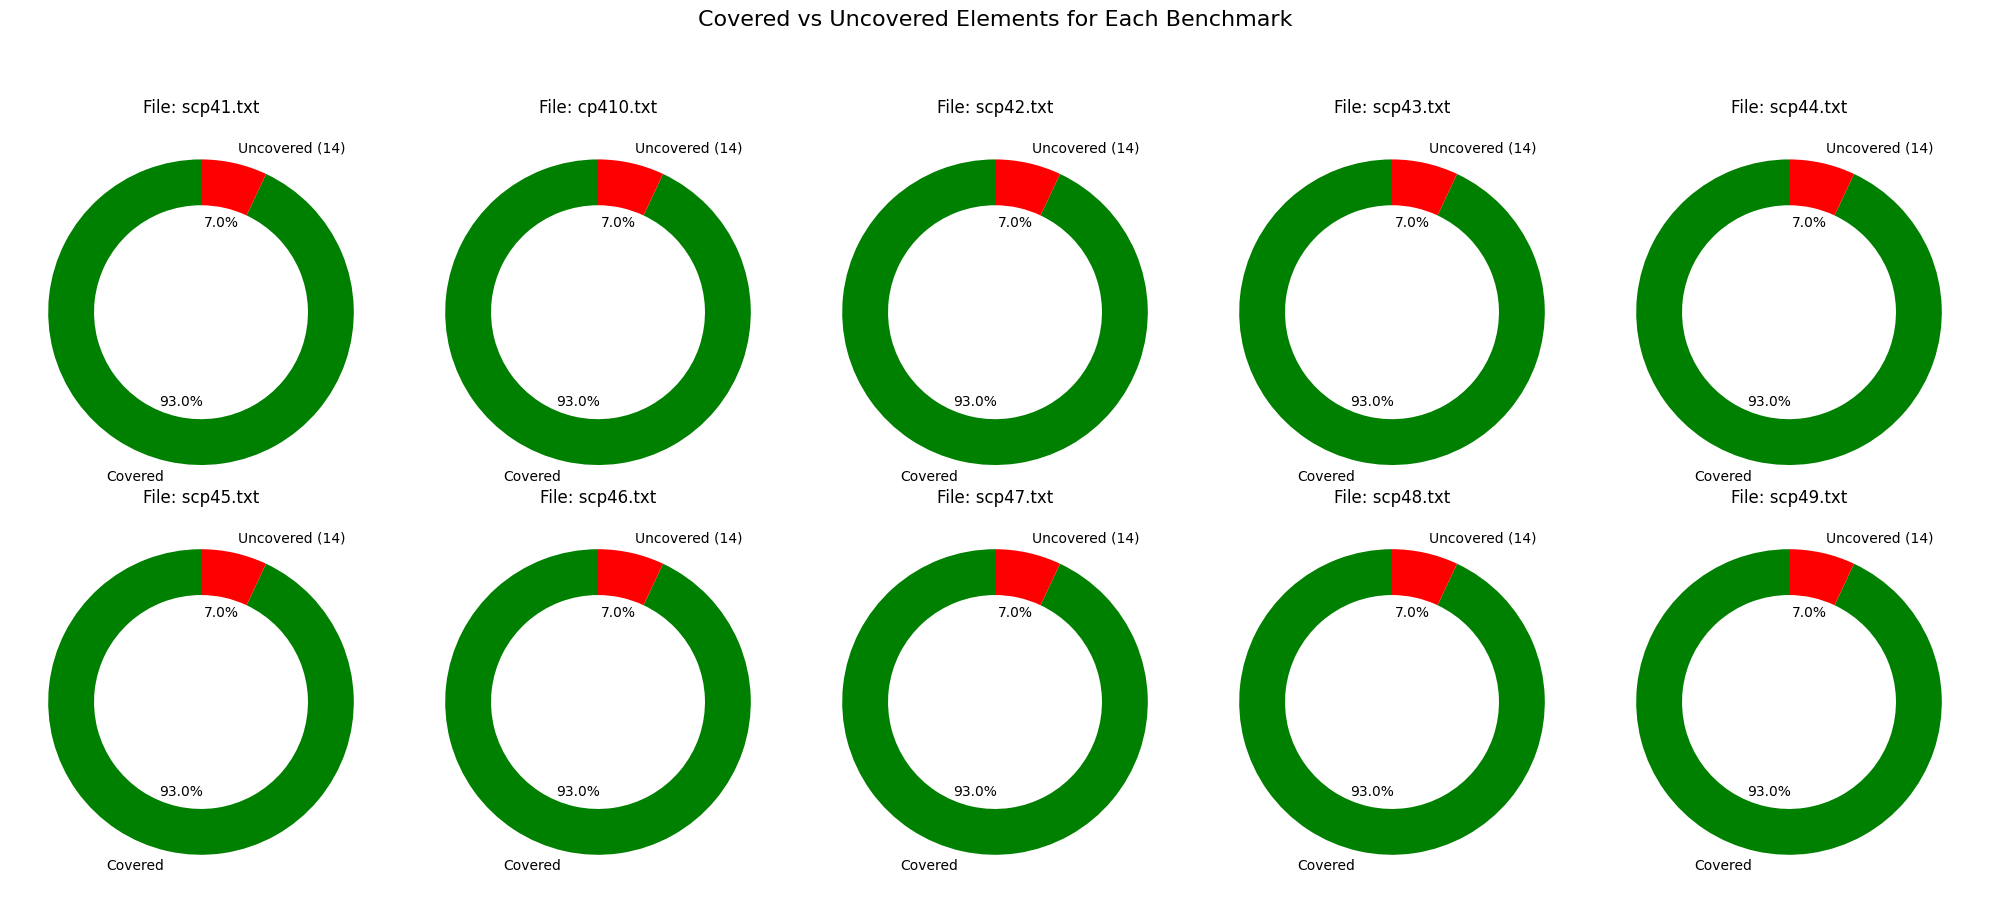

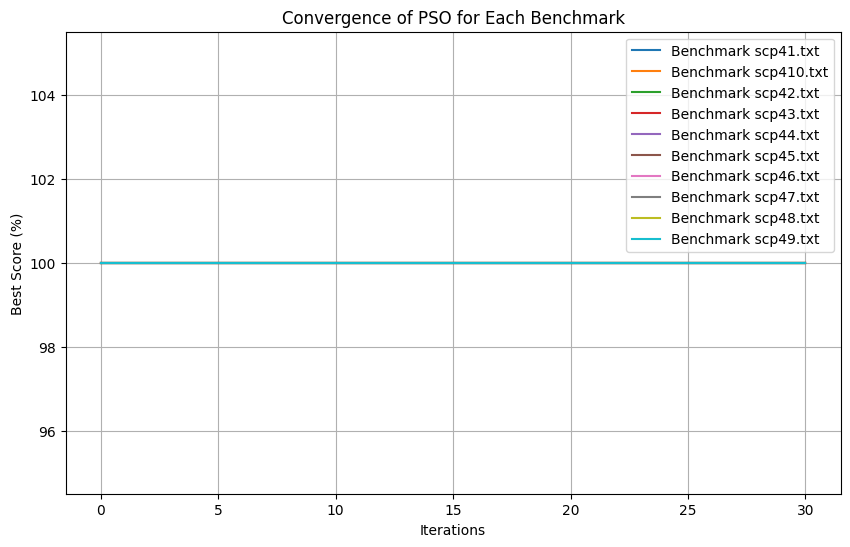

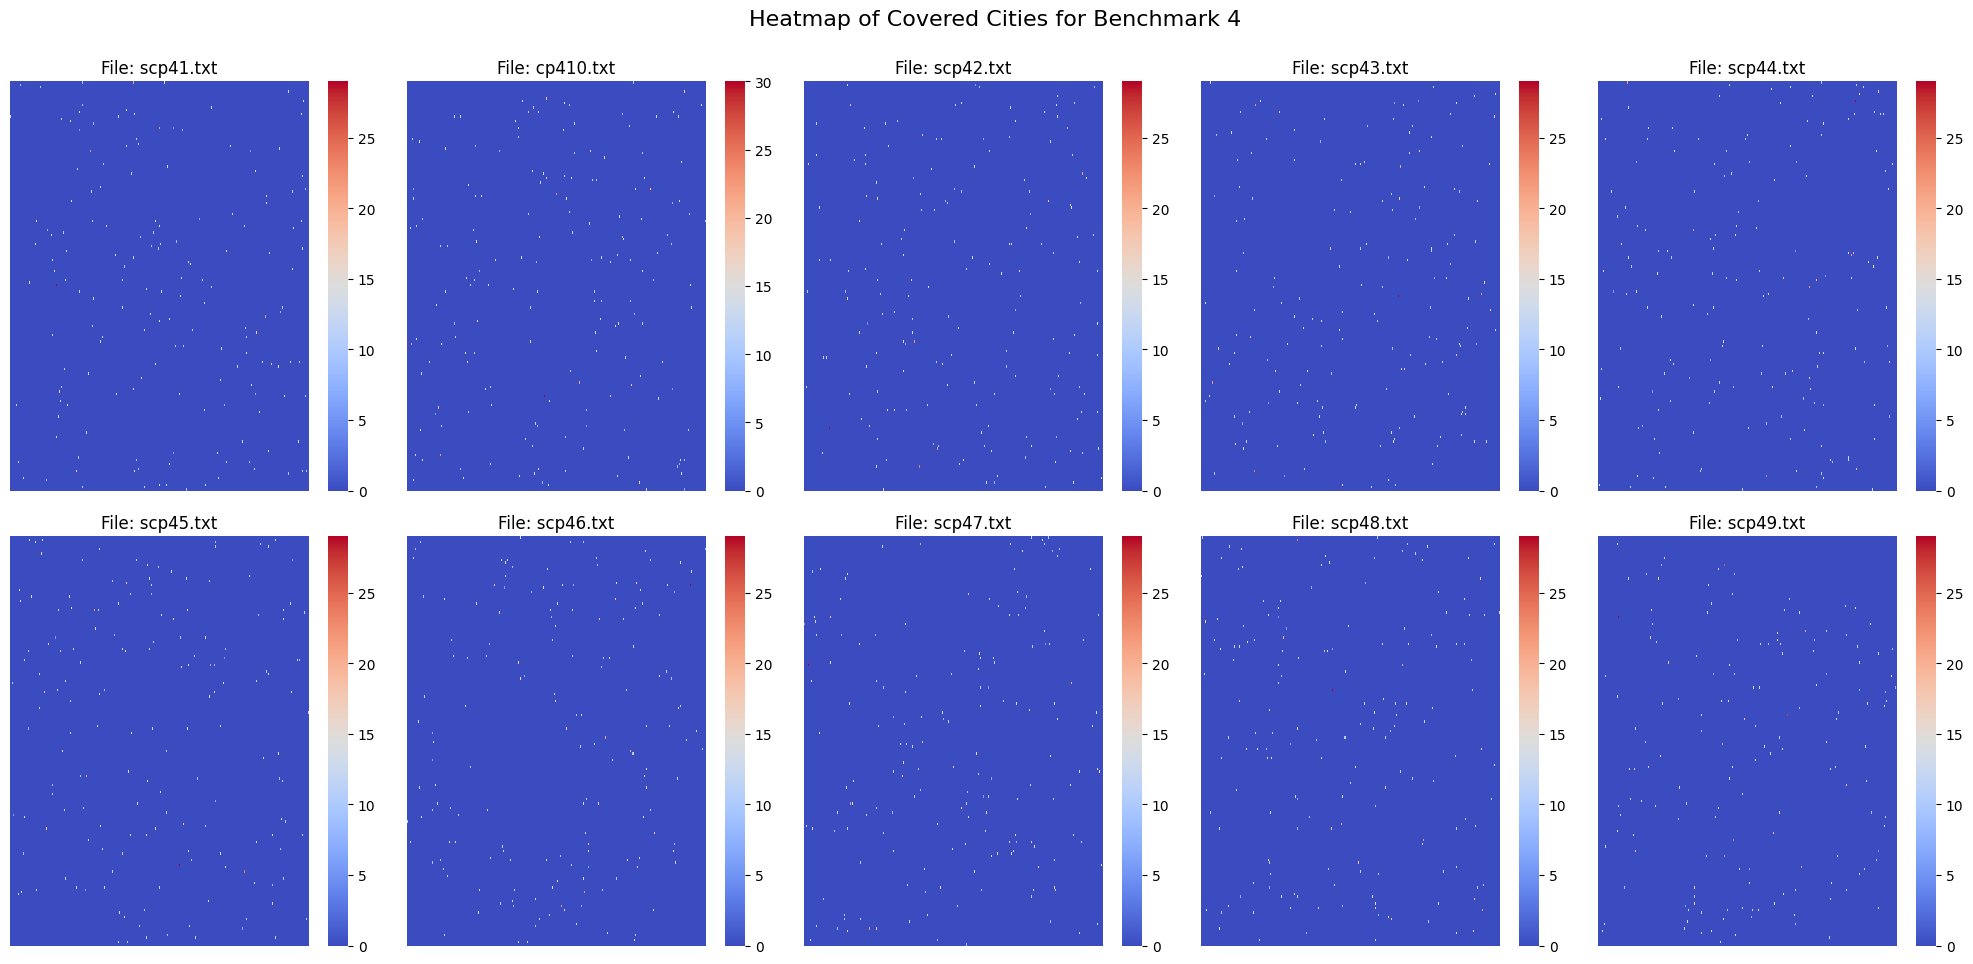


Résumé des résultats après toutes les exécutions :
scp41.txt: Couvert = 200, Score = 100.0000 %, Temps = 1.88s
scp410.txt: Couvert = 200, Score = 100.0000 %, Temps = 1.78s
scp42.txt: Couvert = 200, Score = 100.0000 %, Temps = 2.21s
scp43.txt: Couvert = 200, Score = 100.0000 %, Temps = 1.97s
scp44.txt: Couvert = 200, Score = 100.0000 %, Temps = 1.78s
scp45.txt: Couvert = 200, Score = 100.0000 %, Temps = 1.98s
scp46.txt: Couvert = 200, Score = 100.0000 %, Temps = 2.05s
scp47.txt: Couvert = 200, Score = 100.0000 %, Temps = 1.59s
scp48.txt: Couvert = 200, Score = 100.0000 %, Temps = 1.78s
scp49.txt: Couvert = 200, Score = 100.0000 %, Temps = 1.80s

 Dossier de benchmarks: Benchmark/A

Exécution de PSO sur scpa1.txt...
Arrêt anticipé après 31 itérations.
Optimisation terminée en 2.41 sec - Meilleure couverture: 300, Score final: 100.0000 %

Exécution de PSO sur scpa2.txt...
Arrêt anticipé après 31 itérations.
Optimisation terminée en 2.65 sec - Meilleure couverture: 300, Score final: 100.0

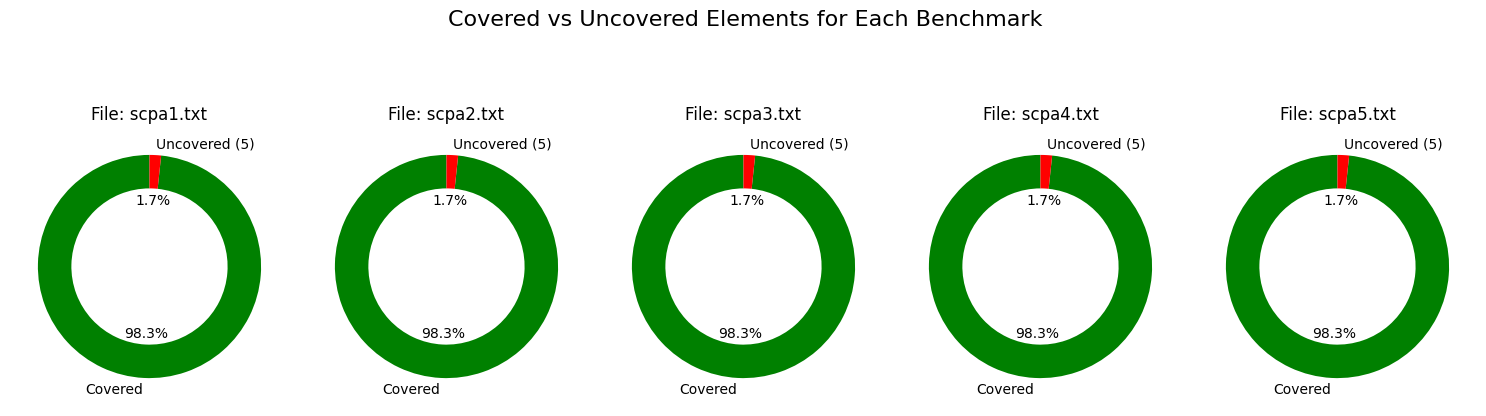

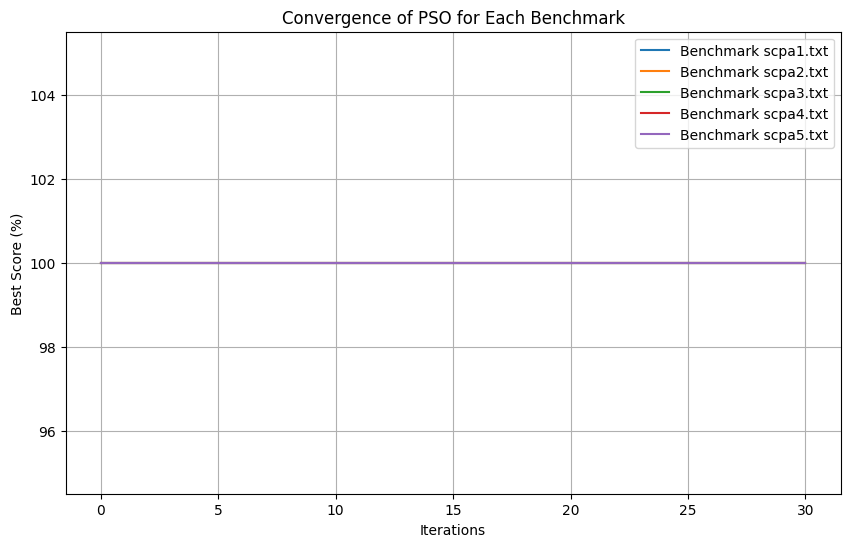

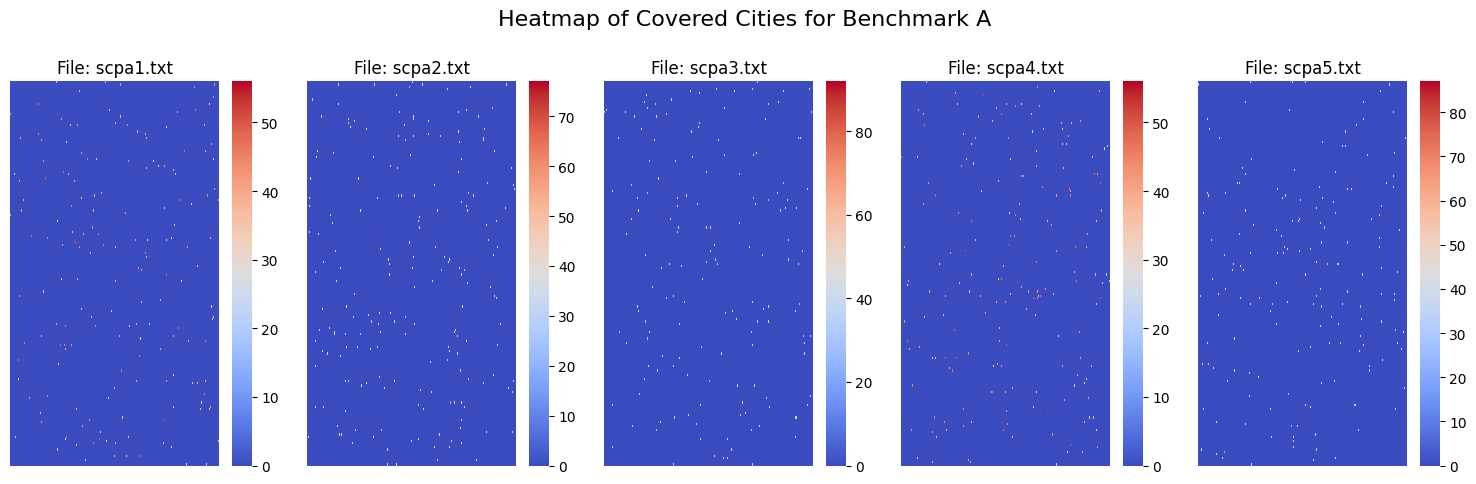


Résumé des résultats après toutes les exécutions :
scpa1.txt: Couvert = 300, Score = 100.0000 %, Temps = 2.41s
scpa2.txt: Couvert = 300, Score = 100.0000 %, Temps = 2.65s
scpa3.txt: Couvert = 300, Score = 100.0000 %, Temps = 2.72s
scpa4.txt: Couvert = 300, Score = 100.0000 %, Temps = 2.84s
scpa5.txt: Couvert = 300, Score = 100.0000 %, Temps = 2.71s

 Dossier de benchmarks: Benchmark/B

Exécution de PSO sur scpb1.txt...
Arrêt anticipé après 31 itérations.
Optimisation terminée en 3.65 sec - Meilleure couverture: 300, Score final: 100.0000 %

Exécution de PSO sur scpb2.txt...
Arrêt anticipé après 31 itérations.
Optimisation terminée en 4.00 sec - Meilleure couverture: 300, Score final: 100.0000 %

Exécution de PSO sur scpb3.txt...
Arrêt anticipé après 31 itérations.
Optimisation terminée en 3.20 sec - Meilleure couverture: 300, Score final: 100.0000 %

Exécution de PSO sur scpb4.txt...
Arrêt anticipé après 31 itérations.
Optimisation terminée en 3.08 sec - Meilleure couverture: 300, Sco

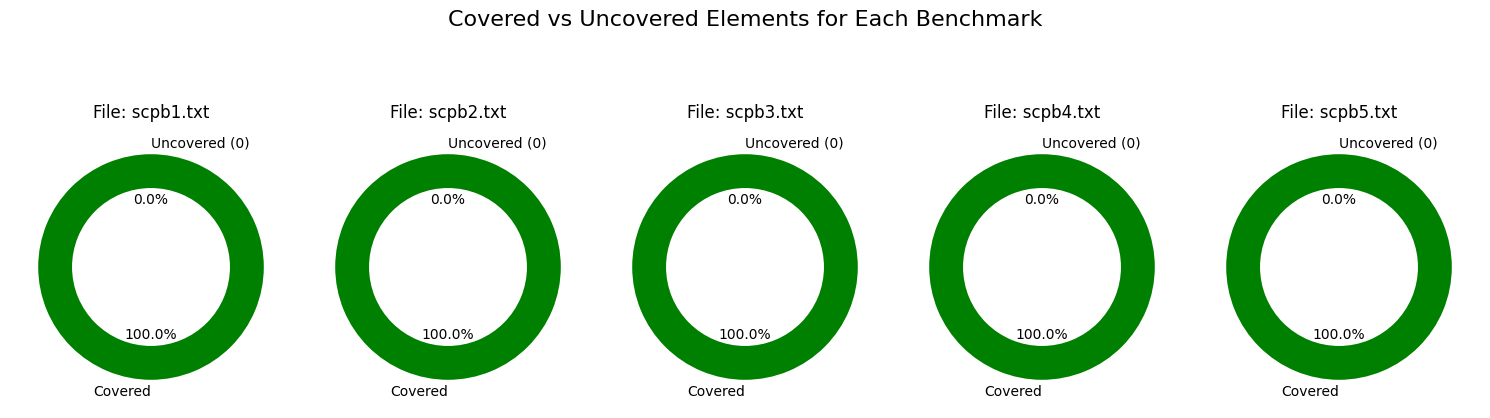

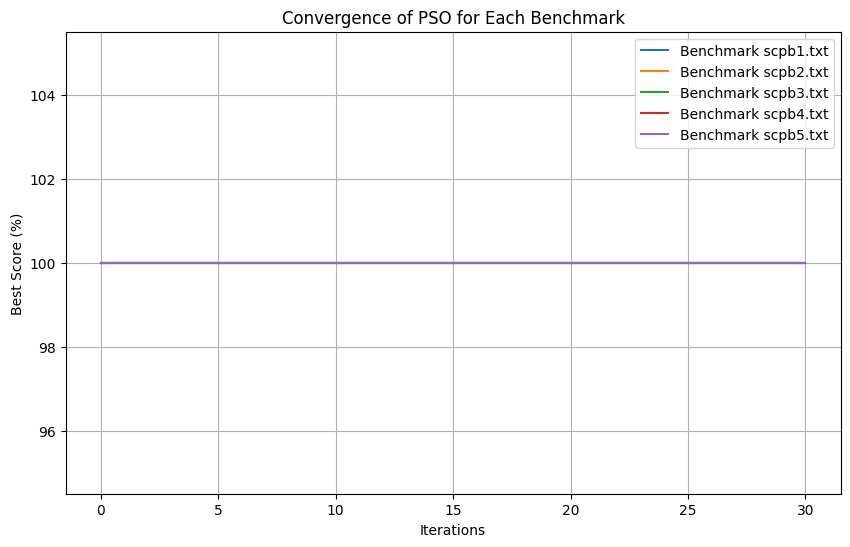

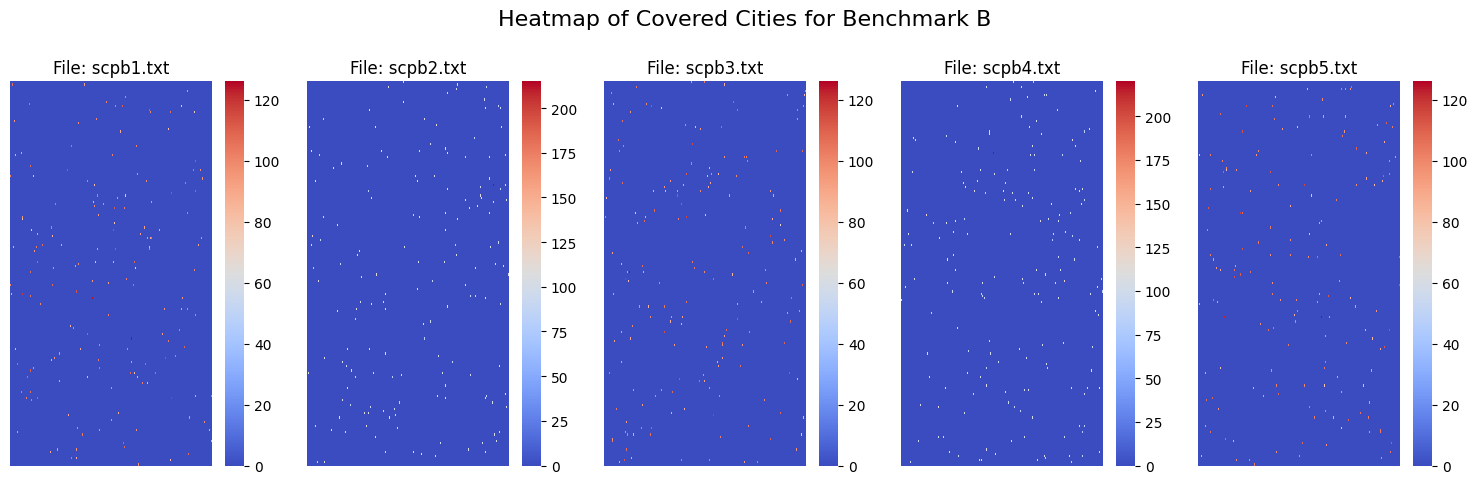


Résumé des résultats après toutes les exécutions :
scpb1.txt: Couvert = 300, Score = 100.0000 %, Temps = 3.65s
scpb2.txt: Couvert = 300, Score = 100.0000 %, Temps = 4.00s
scpb3.txt: Couvert = 300, Score = 100.0000 %, Temps = 3.20s
scpb4.txt: Couvert = 300, Score = 100.0000 %, Temps = 3.08s
scpb5.txt: Couvert = 300, Score = 100.0000 %, Temps = 3.47s

 Dossier de benchmarks: Benchmark/C

Exécution de PSO sur scpc1.txt...
Arrêt anticipé après 31 itérations.
Optimisation terminée en 4.27 sec - Meilleure couverture: 400, Score final: 100.0000 %

Exécution de PSO sur scpc2.txt...
Arrêt anticipé après 31 itérations.
Optimisation terminée en 3.78 sec - Meilleure couverture: 400, Score final: 100.0000 %

Exécution de PSO sur scpc3.txt...
Arrêt anticipé après 31 itérations.
Optimisation terminée en 3.54 sec - Meilleure couverture: 400, Score final: 100.0000 %

Exécution de PSO sur scpc4.txt...
Arrêt anticipé après 31 itérations.
Optimisation terminée en 3.51 sec - Meilleure couverture: 400, Sco

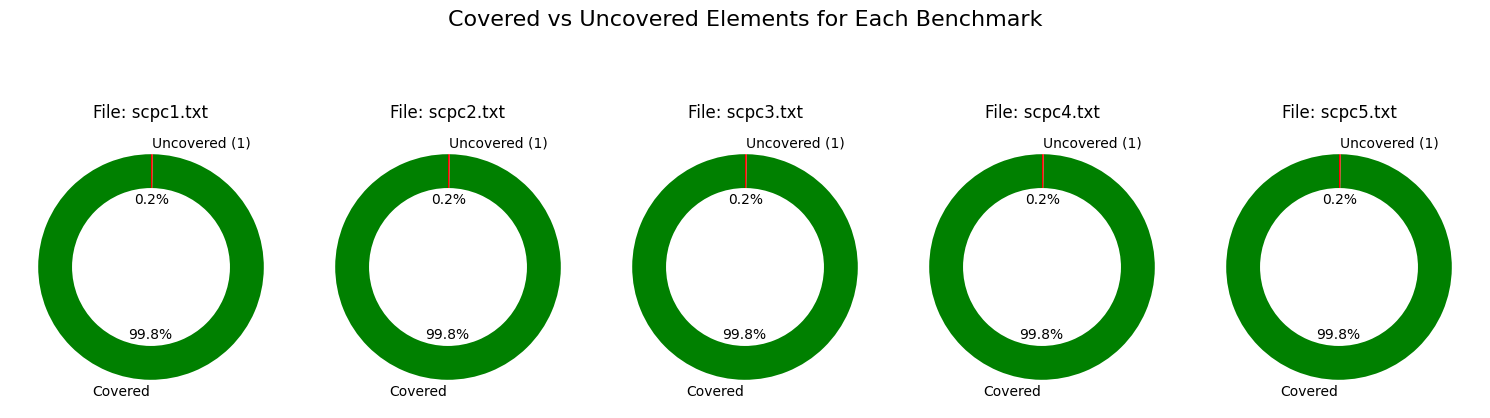

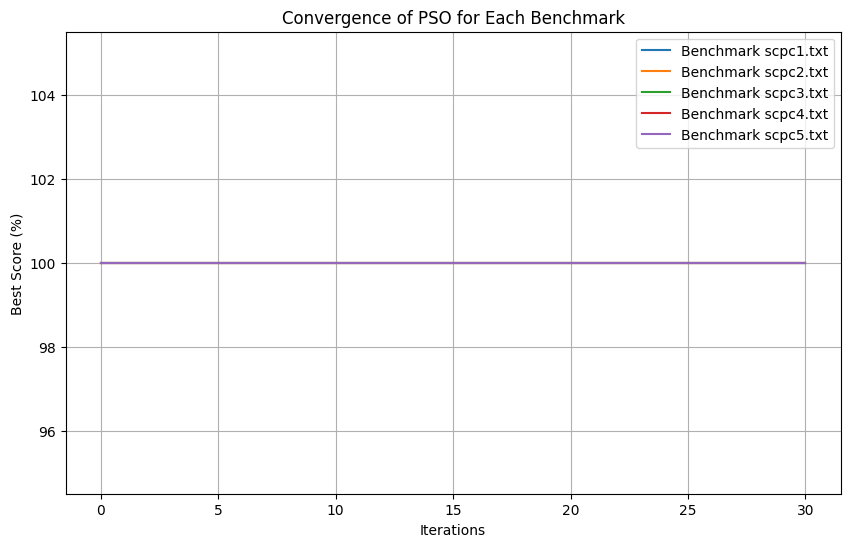

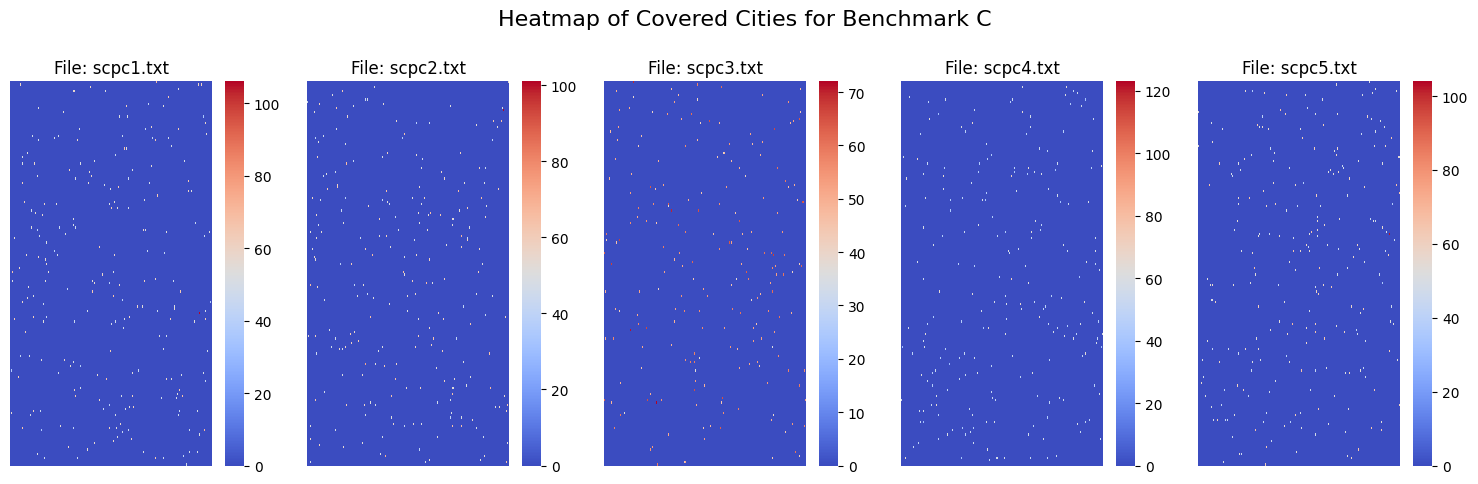


Résumé des résultats après toutes les exécutions :
scpc1.txt: Couvert = 400, Score = 100.0000 %, Temps = 4.27s
scpc2.txt: Couvert = 400, Score = 100.0000 %, Temps = 3.78s
scpc3.txt: Couvert = 400, Score = 100.0000 %, Temps = 3.54s
scpc4.txt: Couvert = 400, Score = 100.0000 %, Temps = 3.51s
scpc5.txt: Couvert = 400, Score = 100.0000 %, Temps = 3.49s

 Résumé des résultats après toutes les exécutions :
Benchmark/4/scp41.txt: Couvert = 200, Score = 100.0000 % , Temps = 1.88s
Benchmark/4/scp410.txt: Couvert = 200, Score = 100.0000 % , Temps = 1.78s
Benchmark/4/scp42.txt: Couvert = 200, Score = 100.0000 % , Temps = 2.21s
Benchmark/4/scp43.txt: Couvert = 200, Score = 100.0000 % , Temps = 1.97s
Benchmark/4/scp44.txt: Couvert = 200, Score = 100.0000 % , Temps = 1.78s
Benchmark/4/scp45.txt: Couvert = 200, Score = 100.0000 % , Temps = 1.98s
Benchmark/4/scp46.txt: Couvert = 200, Score = 100.0000 % , Temps = 2.05s
Benchmark/4/scp47.txt: Couvert = 200, Score = 100.0000 % , Temps = 1.59s
Benchmark/

In [6]:
if __name__ == "__main__":
    #run only one set
    # run_one_file("Benchmark/4/scp41.txt")

    #run all sets in one benchmark
    # run_one_benchmark("Benchmark/4")

    #run all benchmarks
    run_all_benchmarks()